# Quasi static forces from model test

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_martin_vmm as vmm
#import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as vmm
import src.linear_vmm_equations as eq

#import src.models.linear_vmm as model
from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [2]:
#Y_eq = eq.Y_eom.subs(eq.Y_nonlin,sp.solve(eq.fy_eq,Y_nonlin)[0])
Y_eq = eq.Y_eom.subs(eq.Y_lin,sp.solve(eq.fy_eq,Y_lin)[0])

Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [3]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [4]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [5]:
#X_eq = eq.X_eom.subs(eq.X_nonlin,sp.solve(eq.fx_eq,X_nonlin)[0])
X_eq = eq.X_eom.subs(eq.X_lin,sp.solve(eq.fx_eq,X_lin)[0])

eq_X_qs = sp.Eq(X_qs,
      sp.solve(X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [6]:
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [7]:
#N_eq = eq.N_eom.subs(eq.N_nonlin,sp.solve(eq.mz_eq,N_nonlin)[0])
N_eq = eq.N_eom.subs(eq.N_lin,sp.solve(eq.mz_eq,N_lin)[0])

eq_N_qs = sp.Eq(N_qs,
      sp.solve(N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [8]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [9]:
df_runs = mdl.runs()

In [10]:
#id=22773
#id=22616
id=22774
#id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

In [11]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                       Circle 35SB
date                                                           2020-09-23
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [12]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,-0.000656,-0.000609,-0.151412,0.0,-0.339918,10.131507,1.0,-0.005218,-0.005050,-0.139995,0.0,2.105017,11.329219,-0.003520,-0.006034,-0.002206,-0.019749,-0.113032,-0.008359,8.564107,3.610750,-0.091055,9.544681,5.520960,0.110906,-0.003490,0.645772,14.89,0.0,-0.000925,0.000848,0.000502,-0.000611,8.348096,-0.000032,0.001924,1.915455,-0.005175,-0.017840,1.806687,-8.724901e-03,8.369782,0.945042,-0.000008,-0.000052,-0.000524,-0.000006,-0.000646,-0.000004,0.000012,0.945042,0.000086,-0.017840,-0.000008,-0.000006,1.806687,-0.000004,0.000012,-0.000091,0.003490,0.945042
0.010002,0.0,1.0,-0.000656,-0.000656,-0.396389,0.0,0.219698,10.131507,1.0,-0.005245,-0.005439,-0.111403,0.0,-0.924629,11.329219,-0.015771,-0.022151,-0.006724,-0.002355,-0.080796,-0.015448,8.593354,3.640363,-0.094302,9.547651,5.524301,0.108929,-0.003490,0.645772,14.89,0.0,-0.000975,0.000909,-0.000228,-0.000698,8.367255,-0.000084,0.001745,0.953896,-0.003781,0.000231,0.901220,-4.362014e-03,8.369043,0.932046,-0.001763,-0.000073,-0.000516,-0.000060,-0.000682,-0.000111,0.000104,0.932046,0.000120,0.000231,-0.001762,-0.000061,0.901220,-0.000111,0.000104,-0.000128,0.003490,0.932046
0.020002,0.0,1.0,-0.000621,-0.000656,-0.493565,0.0,0.605640,10.131507,1.0,-0.005259,-0.005439,-0.028020,0.0,-1.870188,11.329219,0.040328,0.001701,0.022316,0.053691,-0.053718,-0.031559,8.604683,3.695781,-0.095392,9.543788,5.475323,0.105839,-0.003497,0.645772,14.89,0.0,-0.001125,0.000796,0.000519,-0.000698,8.367180,-0.000107,0.001928,0.427952,0.004017,0.000190,0.018491,6.938894e-18,8.370812,0.928423,-0.002983,-0.000080,-0.000496,-0.000110,-0.000694,-0.000185,0.000202,0.928423,0.000148,0.000190,-0.002983,-0.000112,0.018491,-0.000185,0.000202,-0.000160,0.003497,0.928423
0.030022,0.0,1.0,-0.000635,-0.000656,-0.352199,0.0,-0.031164,10.131507,1.0,-0.005231,-0.005439,0.023558,0.0,-2.352615,11.329219,0.015180,0.027487,0.035222,-0.044229,-0.123347,-0.007714,8.579641,3.766466,-0.094054,9.532289,5.378049,0.102575,-0.003490,0.645772,14.89,0.0,-0.001300,0.000882,-0.000217,-0.000698,8.375840,-0.000003,0.001749,0.933582,0.000628,0.000602,-0.237507,6.938894e-18,8.377828,0.929986,-0.003219,-0.000046,-0.000502,-0.000152,-0.000702,-0.000247,0.000302,0.929986,0.000151,0.000602,-0.003218,-0.000154,-0.237507,-0.000247,0.000302,-0.000162,0.003490,0.929986
0.040002,0.0,1.0,-0.000649,-0.000656,-0.056530,0.0,-0.224135,10.131507,1.0,-0.005266,-0.005439,-0.018784,0.0,-3.356065,11.329219,0.041617,0.022975,0.011345,-0.012663,-0.047270,0.037397,8.563477,3.843375,-0.090846,9.541657,5.267491,0.100237,-0.003490,0.645772,14.89,0.0,-0.001475,0.000861,0.000558,-0.000698,8.385846,-0.000094,0.001939,1.459629,-0.003893,-0.004538,-0.038761,-4.359610e-03,8.387742,0.932423,-0.002933,-0.000076,-0.000519,-0.000207,-0.000716,-0.000297,0.000401,0.932423,0.000150,-0.004538,-0.002932,-0.000209,-0.038761,-0.000297,0.000401,-0.000160,0.003490,0.932423


In [13]:
df['thrust'] = df['Prop/PS/Thrust'] + df['Prop/SB/Thrust']
df['U'] = df['V']

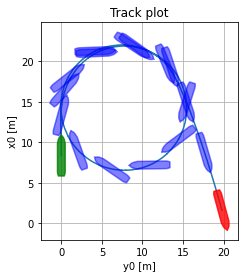

In [14]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [56]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [16]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [18]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

df_parameters['brix_prime'].fillna(0, inplace=True)
#df_parameters['brix_SI'].fillna(0, inplace=True)



In [19]:
df_parameters

,symbol,dof,coord,state,denominator,brix,brix_lambda,brix_prime
Xudot,X_{\dot{u}},X,u,dot,0.5*L**3*rho,2.0*m/(L**3*rho*(pi*sqrt(L**3/volume) - 14)),<function _lambdifygenerated at 0x000002219476...,0.000179
Xvdot,X_{\dot{v}},X,v,dot,0.5*L**3*rho,NaN,NaN,0.000000
Xrdot,X_{\dot{r}},X,r,dot,0.5*L**4*rho,NaN,NaN,0.000000
Yudot,Y_{\dot{u}},Y,u,dot,0.5*L**3*rho,NaN,NaN,0.000000
Yvdot,Y_{\dot{v}},Y,v,dot,0.5*L**3*rho,-pi*T**2*(-5.1*B**2/L**2 + 0.16*B*CB/T + 1)/L**2,<function _lambdifygenerated at 0x000002219476...,-0.006109
Yrdot,Y_{\dot{r}},Y,r,dot,0.5*L**4*rho,-pi*T**2*(-0.0033*B**2/T**2 + 0.67*B/L)/L**2,<function _lambdifygenerated at 0x00000221946F...,-0.000303
Nudot,N_{\dot{u}},N,u,dot,0.5*L**4*rho,NaN,NaN,0.000000
Nvdot,N_{\dot{v}},N,v,dot,0.5*L**4*rho,-pi*T**2*(-0.04*B/T + 1.1*B/L)/L**2,<function _lambdifygenerated at 0x000002219476...,-0.000128
Nrdot,N_{\dot{r}},N,r,dot,0.5*L**5*rho,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,<function _lambdifygenerated at 0x000002219476...,-0.000299
Xthrust,X_{thrust},X,thrust,,1.00000000000000,NaN,NaN,0.000000


In [22]:
df_parameters['prime'] = df_parameters['brix_prime']

def to_SI(row):
    
    prime = row['prime']
    denominator = row['denominator']
    lamda = lambdify(denominator)
    try:
        denominator_value = run(lamda, inputs=ship_parameters)
        SI = prime*denominator_value
    except:
        return None
    else:
        return SI
    
df_parameters['brix_SI'] = df_parameters.apply(to_SI, axis=1)
    

In [23]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])
df['X_qs'] = run(X_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])
df['N_qs'] = run(N_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])

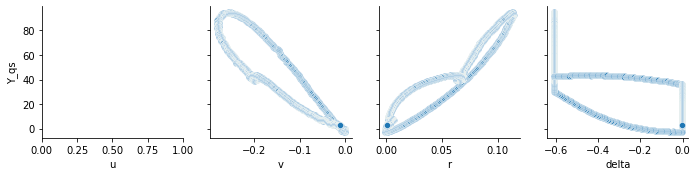

In [24]:
g = sns.PairGrid(df, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

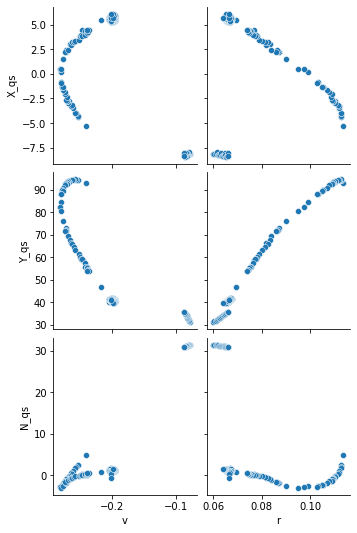

In [25]:
mask = df['delta'] <= df['delta'].quantile(q=0.01)
df_min = df.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:xlabel='time'>

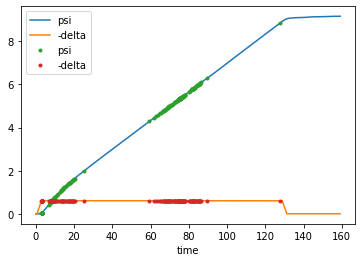

In [26]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_min.plot(y=['psi','-delta'], style='.', ax=ax)

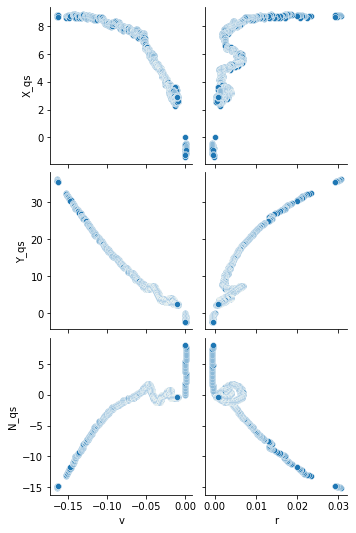

In [27]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:xlabel='time'>

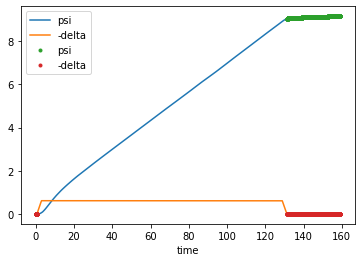

In [28]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_max.plot(y=['psi','-delta'], style='.', ax=ax)

# Regression (linear model)

## N

In [29]:
Math(vlatex(eq.N_qs_eq))

<IPython.core.display.Math object>

In [30]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [31]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{delta}],
[    N_{r}],
[    N_{u}],
[    N_{v}]]))

In [32]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [33]:
diff_eq_N.eq_y

Eq(y, N_)

In [34]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [35]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                          1.304e+04
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        10:20:51   Log-Likelihood:                         -36029.
No. Observations:               15915   AIC:                                  7.207e+04
Df Residuals:                   15911   BIC:                                  7.210e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta       -25.7849      0.232   -111.080      0.000     -26.240     -25.330
Nr           172.9249      2.382     72.609      0.000     168.257     177.593
Nu             7.4297      0.064    115.374      0.000       7.304       7.556
Nv           144.4239      0.700    206.350      0.000     143.052     145.796
==============================================================================
Omnibus:                     4103.267   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20479.329
Skew:                           1.160   Prob(JB):                         0.00
Kurtosis:                       8.050   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

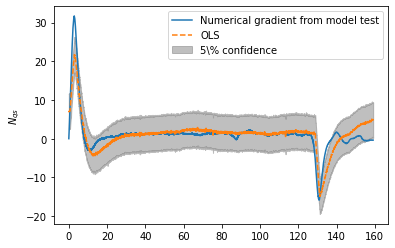

In [36]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [37]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.429e+06
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        10:20:54   Log-Likelihood:                         -31311.
No. Observations:               15915   AIC:                                  6.263e+04
Df Residuals:                   15911   BIC:                                  6.266e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta        72.1773      0.173    418.232      0.000      71.839      72.516
Yr          1036.3489      1.771    585.310      0.000    1032.878    1039.819
Yu             0.3907      0.048      8.160      0.000       0.297       0.485
Yv           -80.3850      0.520   -154.485      0.000     -81.405     -79.365
==============================================================================
Omnibus:                     1574.025   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12138.618
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                       7.273   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

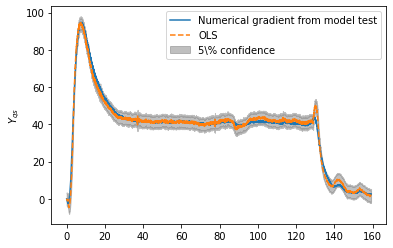

In [38]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [39]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r,thrust])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   X_qs   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          7.657e+04
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        10:20:57   Log-Likelihood:                         -25990.
No. Observations:               15915   AIC:                                  5.199e+04
Df Residuals:                   15911   BIC:                                  5.202e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta       -12.3128      0.124    -99.673      0.000     -12.555     -12.071
Xr          -362.7276      1.267   -286.196      0.000    -365.212    -360.243
Xu             2.1252      0.034     62.012      0.000       2.058       2.192
Xv          -104.0185      0.372   -279.270      0.000    -104.749    -103.288
==============================================================================
Omnibus:                     6045.688   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26902.682
Skew:                          -1.831   Prob(JB):                         0.00
Kurtosis:                       8.211   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

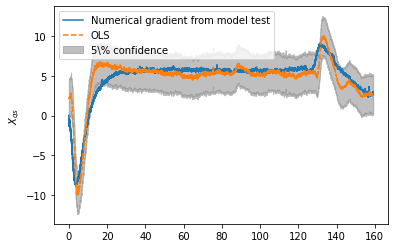

In [40]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [41]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [45]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['SI'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_SI'])  # prefer regressed
df_parameters_all['SI'].fillna(0,inplace=True)

In [46]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_SI,brix_prime,regressed,coord,denominator,dof,prime,state,symbol,SI
Ndelta,0.000000e+00,-25.329856,-26.239855,NaN,NaN,0.000000,-25.784856,delta,0.5*L**3*U**2*rho,N,0.000000,,N_{delta},-25.784856
Ndeltadelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,0.5*L**3*U**2*rho,N,0.000000,,N_{deltadelta},0.000000
Ndeltadeltadelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,deltadeltadelta,0.5*L**3*U**2*rho,N,0.000000,,N_{deltadeltadelta},0.000000
Nr,0.000000e+00,177.593031,168.256674,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,NaN,-0.001719,172.924853,r,0.5*L**4*U*rho,N,-0.001719,,N_{r},172.924853
Nrdelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,0.5*L**4*U*rho,N,0.000000,,N_{rdelta},0.000000
Nrdeltadelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,rdeltadelta,0.5*L**4*U*rho,N,0.000000,,N_{rdeltadelta},0.000000
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-473.515426,-0.000299,NaN,r,0.5*L**5*rho,N,-0.000299,dot,N_{\dot{r}},-473.515426
Nrr,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,rr,0.5*L**5*rho,N,0.000000,,N_{rr},0.000000
Nrrdelta,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,rrdelta,0.5*L**5*rho,N,0.000000,,N_{rrdelta},0.000000
Nrrr,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,rrr,0.5*L**6*rho/U,N,0.000000,,N_{rrr},0.000000


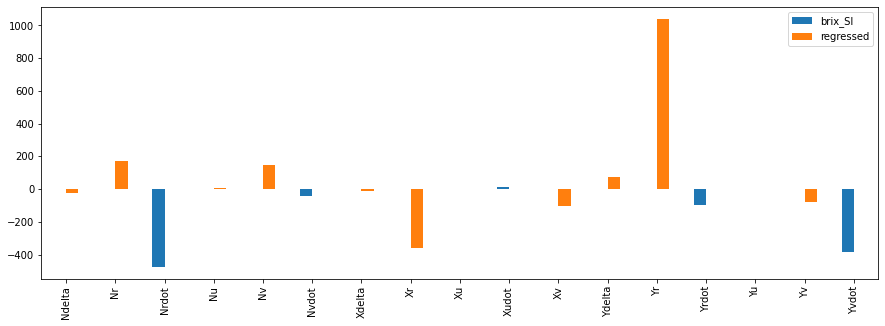

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
mask = ((df_parameters_all['brix_prime'] != 0) |
        (df_parameters_all['regressed']).notnull())
        
df_parameters_plot = df_parameters_all.loc[mask]
df_parameters_plot.plot.bar(y=['brix_SI','regressed'], ax=ax);

# Simulate captive

In [48]:
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [49]:
df['X_qs_pred'] = run(function=X_qs_lambda, inputs=df, **df_parameters_all['SI'])
df['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df, **df_parameters_all['SI'])
df['N_qs_pred'] = run(function=N_qs_lambda, inputs=df, **df_parameters_all['SI'])


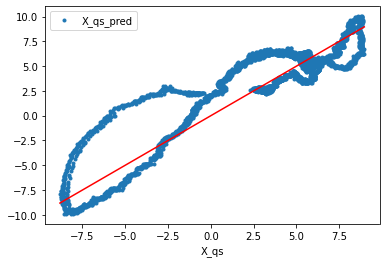

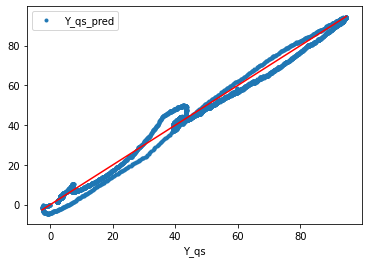

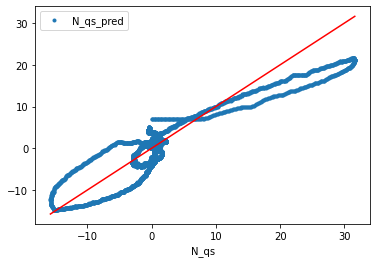

In [50]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    df.plot(x=key, y=f'{key}_pred',style='.', ax=ax)
    ax.plot([df[key].min(), df[key].max()], [df[key].min(), df[key].max()], 'r-')

In [51]:
subs=[
    (eq.p.Xvdot,0),
    (eq.p.Xrdot,0),
    (eq.p.Yudot,0),
    (eq.p.Yrdot,0),
    (eq.p.Nudot,0),
    (eq.p.Nvdot,0),   
]

Math(vlatex(eq.X_eq.subs(subs)))

<IPython.core.display.Math object>

In [52]:
Math(vlatex(eq.Y_eq.subs(subs)))

<IPython.core.display.Math object>

In [53]:
Math(vlatex(eq.N_eq.subs(subs)))

<IPython.core.display.Math object>

In [54]:
Math(vlatex(sp.solve(eq.N_eq.subs(subs),r.diff())[0]))

<IPython.core.display.Math object>

In [55]:
import src.models.linear_vmm as vmm

# Simulation

In [ ]:
#fig,ax=plt.subplots()
#df_prime.plot(y='t', ax=ax, label='actual')
#ax.plot(df.index, df.index/(ship_parameters['L']/df['V'].mean()), label='mean')
#ax.plot(df.index, df.index/(ship_parameters['L']/df['V'].min()), label='min')
#ax.plot(df.index, df.index/(ship_parameters['L']/np.sqrt(df_0['u']**2 + df_0['v']**2)), label='inital')
#ax.legend()

In [ ]:
df_ = df.iloc[0:1500].copy()
t = df_.index
control = df_[['delta','thrust']]
#control = {'delta':0,}

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi']
    }

parameters = df_parameters_all['SI']
parameters2 = parameters.copy()
ship_parameters2 = ship_parameters.copy()

#simulation = vmm.NonLinearSimulation()
simulation = vmm.LinearSimulation()
t_span = [t.min(),t.max()]

solution = solve_ivp(fun=simulation.step, t_span=t_span, y0=list(y0.values()), t_eval=t, 
            args=(parameters2, ship_parameters, control))

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)
#
columns = list(y0.keys())
df_result = pd.DataFrame(data=solution.y.T, columns=columns)
df_result.index=t[0:len(df_result)]

#
##df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)
#
#df_result_prime.plot(y='u')
#df_result_prime.plot(y='v')
#df_result_prime.plot(y='r')


In [ ]:
fig,ax=plt.subplots()
track_plot(df=df, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)



In [ ]:
simulation.u1d_lambda

In [ ]:
Math(vlatex(vmm.u1d_eq))

In [ ]:
Math(vlatex(vmm.v1d_eq))

In [ ]:
Math(vlatex(vmm.r1d_eq))

In [ ]:
subs = [
    (x_G,0),

    (eq.p.Yrdot,0),
    
]
Math(vlatex(vmm.v1d_eq.subs(subs)))

In [ ]:
Math(vlatex(vmm.r1d_eq))

In [ ]:
eqs = [eq.X_eq, eq.Y_eq, eq.N_eq]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

In [ ]:
solution[0][u.diff()]

In [ ]:
Math(valtexeq.X_eq